In [460]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt



from itertools import cycle
import datetime as dt
import random 
import os
from matplotlib.pyplot import figure

import torch
import torch.nn as nn
import matplotlib.pyplot as plt




%matplotlib inline

 

In [461]:
import torch



device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [462]:
import pandas as pd
import os


def add_features(dataframe):

    new_df = dataframe.copy()
    for column in dataframe.columns:
        new_df[(column + "_Diff")] = new_df[column].diff(1).fillna(0)
        new_df[(column + "_DailyAvg")] = new_df[column].rolling(24).mean().fillna(0)
        new_df[(column + "_DailyDiff")] = new_df[column].diff(24).fillna(0)

    return new_df

def extract_data(data_dir, file_name):
    table = pd.read_csv(os.path.join(data_dir, file_name))
    table = table.drop(table.columns[0], axis=1)
    table = add_features(table)
    print(table)
    header = table.columns.values
    data = table.astype(float).values

    return header, torch.tensor(data, dtype=torch.float)


def normalize_data(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)



In [463]:
import numpy as np
import torch


def floating_window_batch_generator(
    data,
    sample_len,
    target_len,
    min_index,
    max_index,
    shuffle=False,
    batch_size=128,
    step=6,
):
    """
    Generate a batch of subsequences of data.

    Args:
        data: (samples, features)
        sample_len: number of samples in the past.
        target_len: number of samples to predict
        min_index: index of first sample
        max_index: index after the last sample
        shuffle: (boolean) if False, return batches in chronological order.
        batch_size: (int)
        step: (int) number of timesteps between samples
    """
    n_features = data.shape[-1]
    if max_index is None:
        max_index = len(data) - target_len - 1
    i = min_index

    window_size = (sample_len + target_len) * step

    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index, max_index - (sample_len + target_len) * step, size=batch_size
            )
        else:
            if i + batch_size >= max_index - (sample_len + target_len) * step:
                i = min_index  # reset to beggining
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = torch.zeros((len(rows), sample_len, n_features))
        targets = torch.zeros((len(rows), target_len, n_features))
        for j, row in enumerate(rows):
            indices = range(row, row + window_size, step)
            samples[j] = data[indices[:sample_len]]
            targets[j] = data[indices[sample_len:]]

        yield samples, targets

In [464]:
def plot_samples(samples, targets, feature, figsize=(12, 12)):

    assert feature < samples.shape[-1]

    chosen_sample = samples[0, :, feature]
    chosen_target = targets[0, :, feature]

    plt.figure(figsize=figsize)
    sample_x = np.linspace(0, len(chosen_sample), len(chosen_sample))
    target_x = np.linspace(len(chosen_sample) + 1, len(chosen_sample) + len(chosen_target), len(chosen_target))

    plt.plot(sample_x, chosen_sample, color="red")
    plt.plot(target_x, chosen_target, color="black")

    plt.show()

In [465]:
class Encoder(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )

    def forward(self, src):
        # src = [batch size, src len, n]
        outputs, hidden = self.rnn(src)

        # outputs = [batch size, src len, hid dim]
        # hidden = [batch size, n layers, hid dim]

        return outputs, hidden

In [466]:
class Attention(nn.Module):
    def __init__(self, hid_dim, n_layers):
        super().__init__()
        
        self.attn = nn.Linear(hid_dim * (n_layers + 1), hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [n_layers, batch size, hid dim]
        #encoder_outputs = [batch size, src len,  hid dim]
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        

        #reshape hidden to [batch size, n_layers * hid dim]
        hidden = hidden.permute(1, 0, 2).reshape(batch_size, -1).contiguous()

        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        #hidden = [batch size, src len, n_layers * hid dim]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        #energy = [batch size, src len, hid dim]

        attention = self.v(energy).squeeze(2)
        #attention = [batch size, src len]
        
        return torch.softmax(attention, dim=1)

In [467]:
class Decoder(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout):
        super().__init__()

        self.n_features = n_features
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.GRU(
            input_size=n_features + hid_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.attention = Attention(hid_dim, n_layers).to(device)
        self.fc_out = nn.Linear(2 * hid_dim + n_features, n_features)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size, n features]
        # hidden = [batch size, n layers, hid dim]
        # encoder_outputs = [batch size, src len, hid dim]
    
        input = input.unsqueeze(1)
        # input = [batch size, 1, n features]

        a = self.attention(hidden, encoder_outputs).unsqueeze(1)
        # a = [batch size, 1, src len]

        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, hid dim]

        rnn_input = torch.cat((input, weighted), dim=2)
        # rnn_input = [batch size, 1, (n features + hid dim)]

        output, hidden = self.rnn(rnn_input, hidden)
        # output = [batch size, 1, hid dim]
        # hidden = [n layers, batch size, hid dim]

        pred_input = torch.cat((output, input, weighted), dim=2)
        # pred_input = [batch size, 1, (2 * hid dim + n features)]

        prediction = self.fc_out(pred_input.squeeze(1))

        # prediction = [batch size, n features]

        return prediction, hidden

In [468]:
class Seq2Seq(nn.Module):
    def __init__(self, n_features, hid_dim, n_layers, dropout, device):
        super().__init__()

        self.encoder = Encoder(n_features, hid_dim, n_layers, dropout).to(device)
        self.decoder = Decoder(n_features, hid_dim, n_layers, dropout).to(device)
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [batch size, src len, n features]
        # trg = [batch size, trg len, n features]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        # tensor to store decoder outputs
        outputs = torch.zeros_like(trg).to(self.device)
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, hidden = self.encoder(src)
    
        # first input to the decoder is the last sample
        input = torch.zeros_like(src[:, -1])
        trg_len = trg.shape[1]

        for t in range(trg_len):
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden = self.decoder(input, hidden, encoder_outputs)

            # place predictions in a tensor holding predictions for each token
            outputs[:, t] = output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[:, t] if teacher_force else output

        return outputs

In [469]:
# model fitting
from tqdm import trange
import torch
import inspect
import time


def train(dataloader, model, loss_fn, optimizer, iter_count=None, desired_features=None, teacher_forcing_ratio=0.5):
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0
    average_acc = 0

    for _ in trange(iter_count):
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # y = y.unsqueeze(1).to(torch.float)
        # Compute prediction error

        pred = model(x, y, teacher_forcing_ratio=teacher_forcing_ratio)

        if desired_features is not None:
            pred = pred[:, :, desired_features]
            y = y[:, :, desired_features]
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()

    average_loss /= iter_count

    return average_loss


def eval(dataloader, model, loss_fn, iter_count=None, desired_features=None):
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for _ in trange(iter_count):
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)
            # y = y.unsqueeze(1).to(torch.float)
            pred = model(x, y, teacher_forcing_ratio=0)
            if desired_features is not None:
                pred = pred[:, :, desired_features]
                y = y[:, :, desired_features]

            test_loss += loss_fn(pred, y).item()

    test_loss /= iter_count

    return test_loss


def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    epochs=5,
    train_size=None,
    val_size=None,
    desired_features=None,
    teacher_forcing_ratio=0.5
):
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_size,
            desired_features=desired_features,
            teacher_forcing_ratio=teacher_forcing_ratio
        )
        print("Eval")
        test_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_size,
            desired_features=desired_features,
        )

        print(f"Train Error: Avg loss: {train_loss:>8f} ")
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(test_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    print(f"Total Duration: {total_duration:.2f}")
    average_duration = total_duration / epochs
    print(f"Average Duration: {average_duration:.2f}")
    return history

In [470]:
from typing import Dict, List

import matplotlib.pyplot as plt
# model plot
def plot_history(history:Dict[str, Dict[str, List]]):

    val_data = history['val']
    train_data = history['train']
    nr_metrics = len(train_data.keys())
    fig = plt.figure(figsize=(8, 4*nr_metrics))

    for i, name in enumerate(train_data.keys()):
        ax = fig.add_subplot(nr_metrics, 1, i + 1)
        plt.plot(train_data[name], label='train ' + name, color='b')
        plt.plot(val_data[name], label='val ' + name, color='r')
        plt.title(name)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()
    
    plt.show()    
    


In [471]:
# preprocessing

data_dir = "./datasets/PJM_power/"
fname = "DAYTON_hourly.csv"
header, float_data = extract_data(data_dir, fname)
normalized_data = normalize_data(float_data)

        DAYTON_MW  DAYTON_MW_Diff  DAYTON_MW_DailyAvg  DAYTON_MW_DailyDiff
0          1596.0             0.0            0.000000                  0.0
1          1517.0           -79.0            0.000000                  0.0
2          1486.0           -31.0            0.000000                  0.0
3          1469.0           -17.0            0.000000                  0.0
4          1472.0             3.0            0.000000                  0.0
...           ...             ...                 ...                  ...
121270     2732.0            18.0         2483.416667               -239.0
121271     2724.0            -8.0         2474.750000               -208.0
121272     2664.0           -60.0         2466.375000               -201.0
121273     2614.0           -50.0         2459.833333               -157.0
121274     2552.0           -62.0         2454.750000               -122.0

[121275 rows x 4 columns]


In [472]:
print(header)
print(float_data[:50])

['DAYTON_MW' 'DAYTON_MW_Diff' 'DAYTON_MW_DailyAvg' 'DAYTON_MW_DailyDiff']
tensor([[1596.0000,    0.0000,    0.0000,    0.0000],
        [1517.0000,  -79.0000,    0.0000,    0.0000],
        [1486.0000,  -31.0000,    0.0000,    0.0000],
        [1469.0000,  -17.0000,    0.0000,    0.0000],
        [1472.0000,    3.0000,    0.0000,    0.0000],
        [1518.0000,   46.0000,    0.0000,    0.0000],
        [1598.0000,   80.0000,    0.0000,    0.0000],
        [1691.0000,   93.0000,    0.0000,    0.0000],
        [1748.0000,   57.0000,    0.0000,    0.0000],
        [1825.0000,   77.0000,    0.0000,    0.0000],
        [1880.0000,   55.0000,    0.0000,    0.0000],
        [1891.0000,   11.0000,    0.0000,    0.0000],
        [1874.0000,  -17.0000,    0.0000,    0.0000],
        [1859.0000,  -15.0000,    0.0000,    0.0000],
        [1829.0000,  -30.0000,    0.0000,    0.0000],
        [1807.0000,  -22.0000,    0.0000,    0.0000],
        [1838.0000,   31.0000,    0.0000,    0.0000],
        

In [473]:
sample_len = 240
step = 1
target_len = 24
batch_size = 256
selected_features = None

train_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=0,
    max_index=80000,
    shuffle=True,
    step=step,
    batch_size=batch_size,
    
)

val_generator = floating_window_batch_generator(
    normalized_data,
    sample_len=sample_len,
    target_len=target_len,
    min_index=80001,
    max_index=120000,
    step=step,
    batch_size=batch_size,
    shuffle=True
)



In [474]:
samples, targets = next(train_generator)

In [475]:
print(samples.shape)
print(targets.shape)

torch.Size([256, 240, 4])
torch.Size([256, 24, 4])


DAYTON_MW


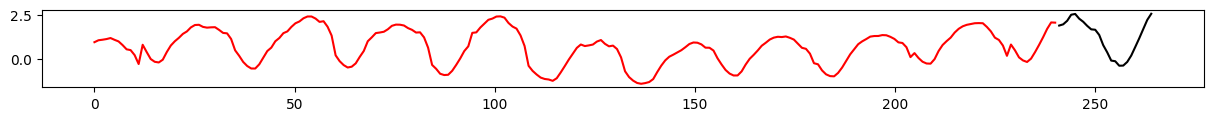

DAYTON_MW_Diff


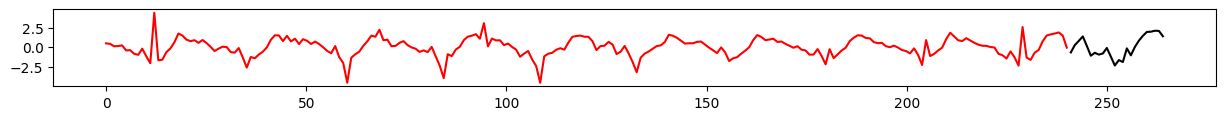

DAYTON_MW_DailyAvg


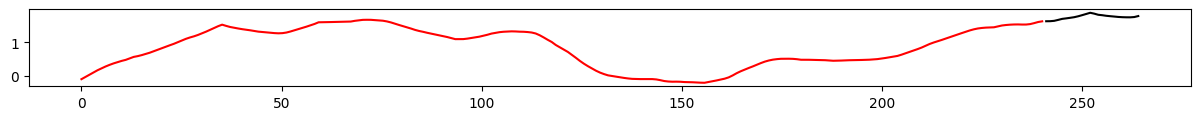

DAYTON_MW_DailyDiff


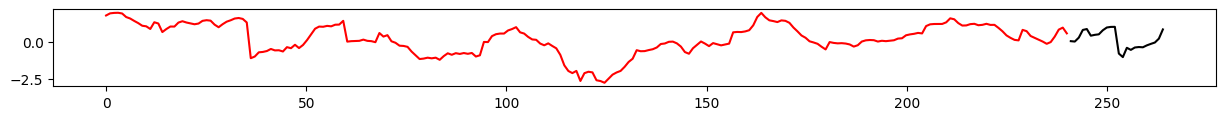

In [476]:

for feature in range(samples.shape[-1]):
    print(header[feature])
    plot_samples(samples, targets, feature, figsize=(15,1))

In [477]:
N_SAMPLES = float_data.shape[1]
HID_DIM = 64
N_LAYERS = 2
DROPOUT = 0


model = Seq2Seq(N_SAMPLES, HID_DIM, N_LAYERS, DROPOUT, device).to(device)

In [478]:
print(model)
from torchinfo import summary

summary(
    model,
    input_size=[(10, sample_len, N_SAMPLES), (10, target_len, N_SAMPLES)],
    col_names=["input_size", "output_size", "num_params", "trainable", "kernel_size"],
    col_width=15,
)

Seq2Seq(
  (encoder): Encoder(
    (rnn): GRU(4, 64, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (rnn): GRU(68, 64, num_layers=2, batch_first=True)
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=64, bias=True)
      (v): Linear(in_features=64, out_features=1, bias=False)
    )
    (fc_out): Linear(in_features=132, out_features=4, bias=True)
  )
)


Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Seq2Seq                                  [10, 240, 4]    [10, 24, 4]     --              True            --
├─Encoder: 1-1                           [10, 240, 4]    [10, 240, 64]   --              True            --
│    └─GRU: 2-1                          [10, 240, 4]    [10, 240, 64]   38,400          True            --
├─Decoder: 1-2                           [10, 4]         [10, 4]         --              True            --
│    └─Attention: 2-2                    [2, 10, 64]     [10, 240]       --              True            --
│    │    └─Linear: 3-1                  [10, 240, 192]  [10, 240, 64]   12,352          True            --
│    │    └─Linear: 3-2                  [10, 240, 64]   [10, 240, 1]    64              True            --
│    └─GRU: 2-3                          [10, 1, 68]     [10, 1, 64]     50,688          True            --
│    └─Linear: 2-4

In [479]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 102,036 trainable parameters


In [480]:
# Fit model

loss_fn = nn.MSELoss()
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = fit_model(
    model,
    train_dataloader=train_generator,
    train_size=100,
    val_dataloader=val_generator,
    val_size=20,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=30,
    desired_features=[0]
)

Epoch 1
-------------------------------
Test


100%|██████████| 100/100 [05:23<00:00,  3.23s/it]


Eval


100%|██████████| 20/20 [00:38<00:00,  1.92s/it]


Train Error: Avg loss: 0.972294 
Test Error: Avg loss: 0.898432 

Epoch 2
-------------------------------
Test


 83%|████████▎ | 83/100 [04:18<00:52,  3.11s/it]


KeyboardInterrupt: 

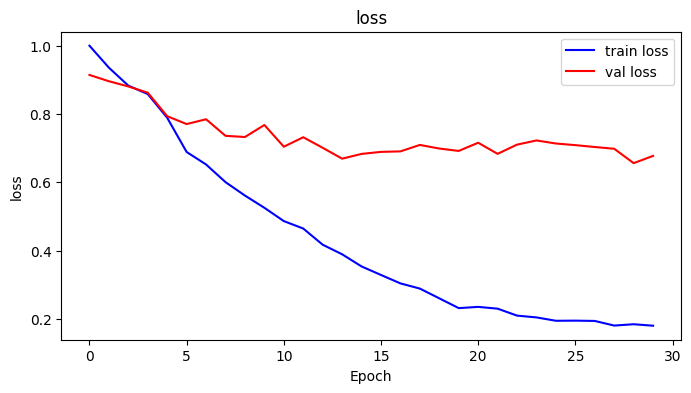

In [ ]:
plot_history(history)

In [ ]:


def make_predictions(model, samples, targets):
    with torch.no_grad():
        output = model(samples.to(device), targets.to(device), teacher_forcing_ratio=0)
    return output

def plot_predictions(samples, targets, output):
    
    for feature in range(samples.shape[-1]):
        print(header[feature])
        temp_sample = samples[0, :, feature]
        temp_target = targets[0, :, feature]
        temp_output = output[0, :, feature].cpu().detach()
        plt.figure(figsize=(20, 4))
        plt.plot(
           torch.cat((temp_sample, temp_target), dim=0), color="black", label="Ground Truth"
        )
        plt.plot(
            torch.cat((temp_sample, temp_output), dim=0), color="red", label="Prediction"
        )
        plt.legend()
        plt.show()




torch.Size([64, 24, 4])


DAYTON_MW


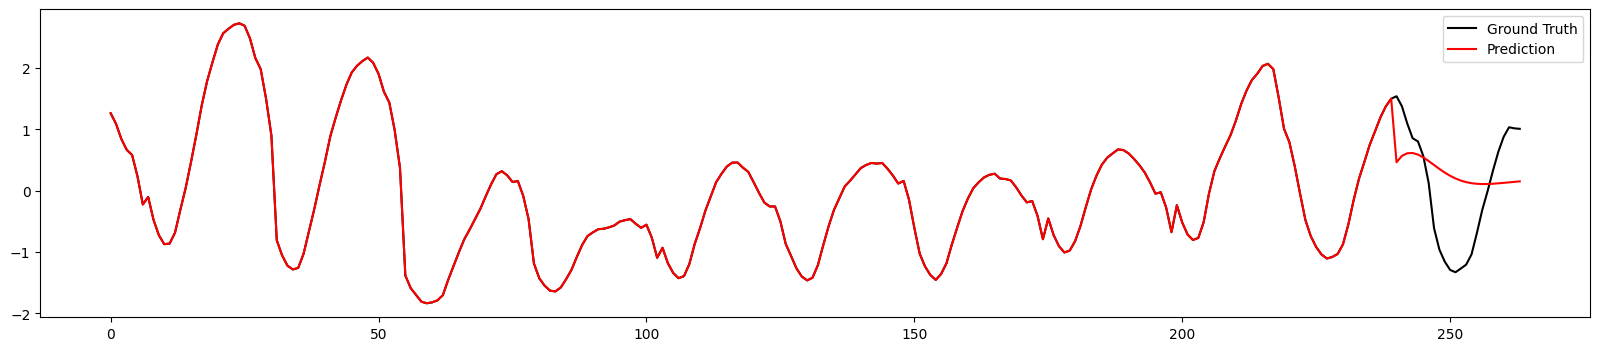

DAYTON_MW_Diff


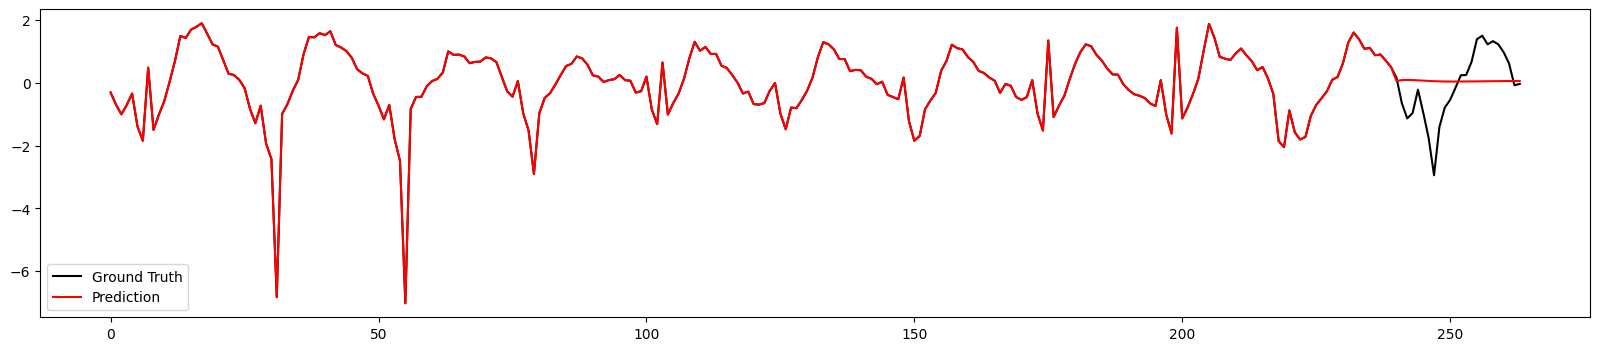

DAYTON_MW_DailyAvg


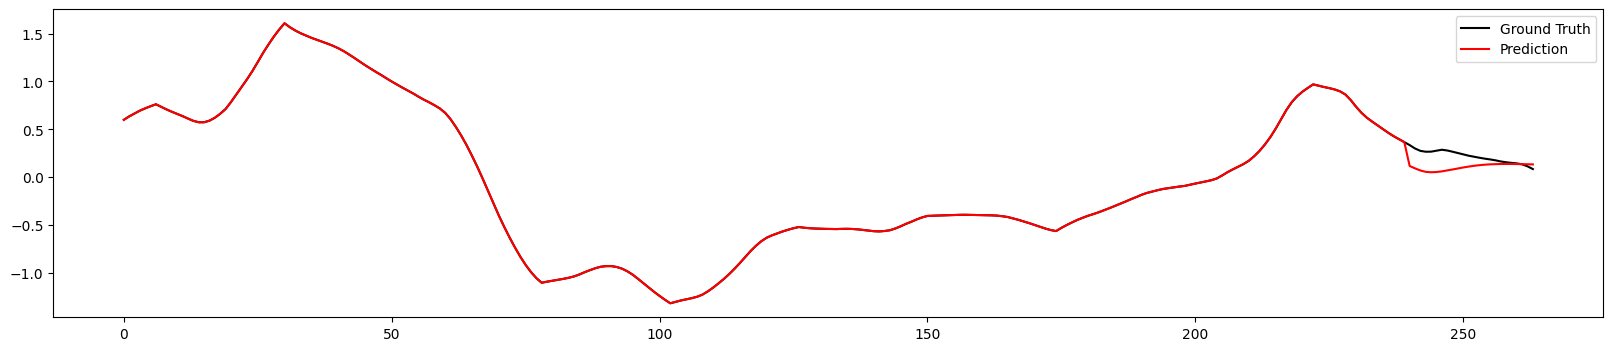

DAYTON_MW_DailyDiff


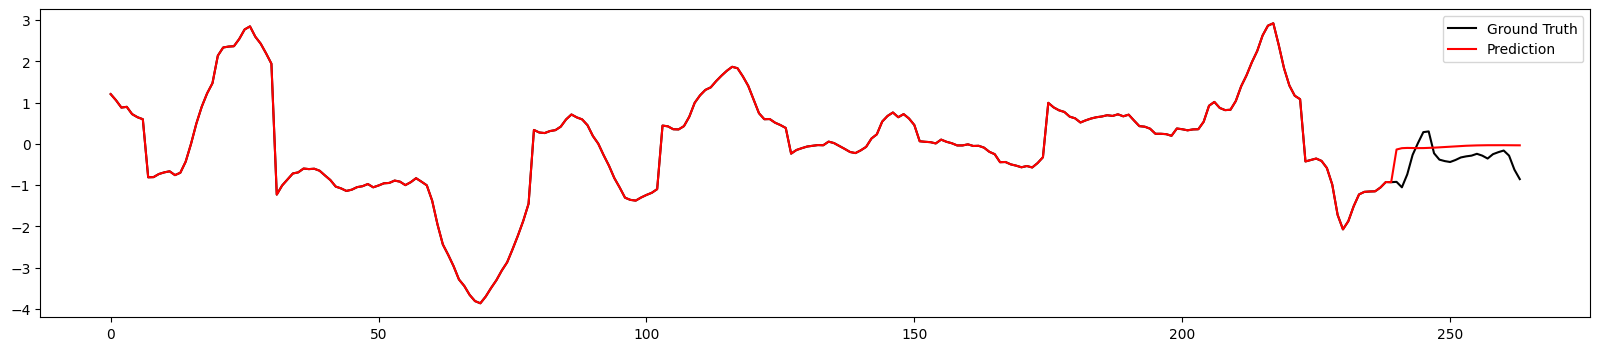

torch.Size([64, 24, 4])
DAYTON_MW


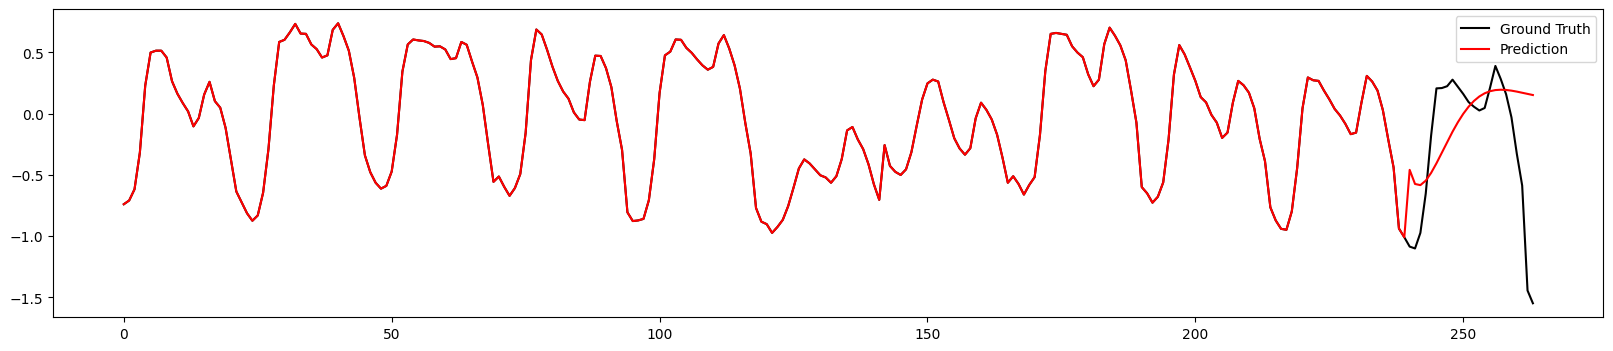

DAYTON_MW_Diff


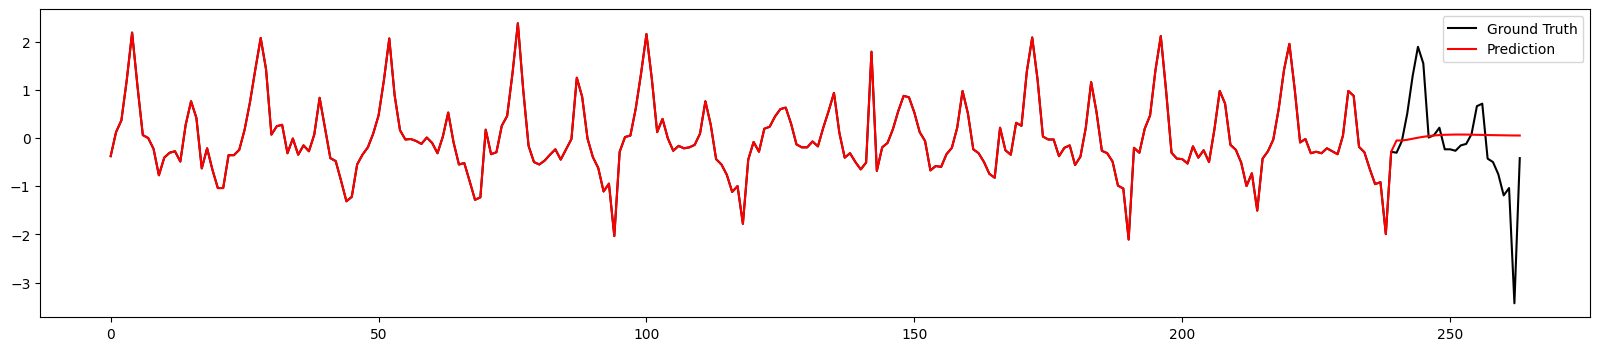

DAYTON_MW_DailyAvg


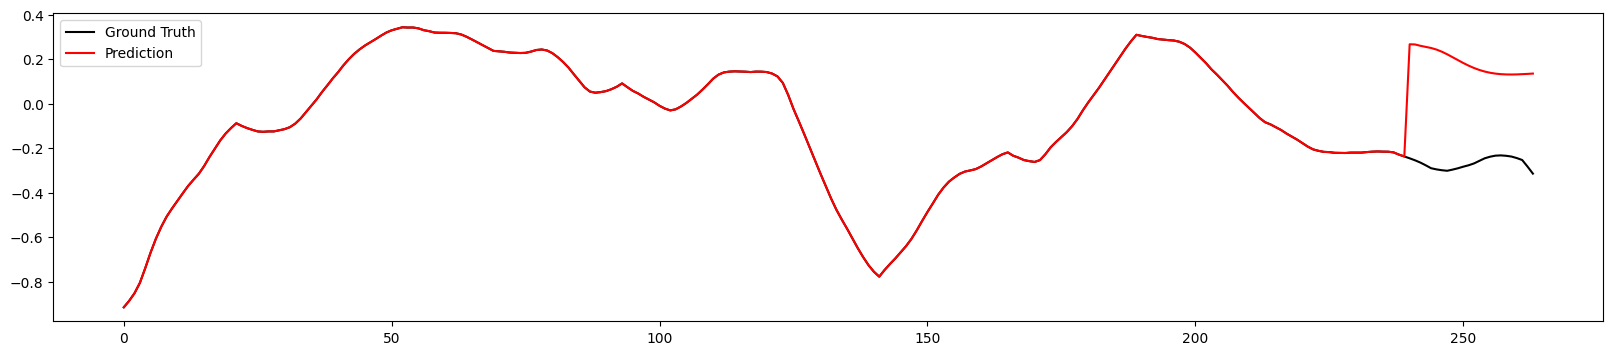

DAYTON_MW_DailyDiff


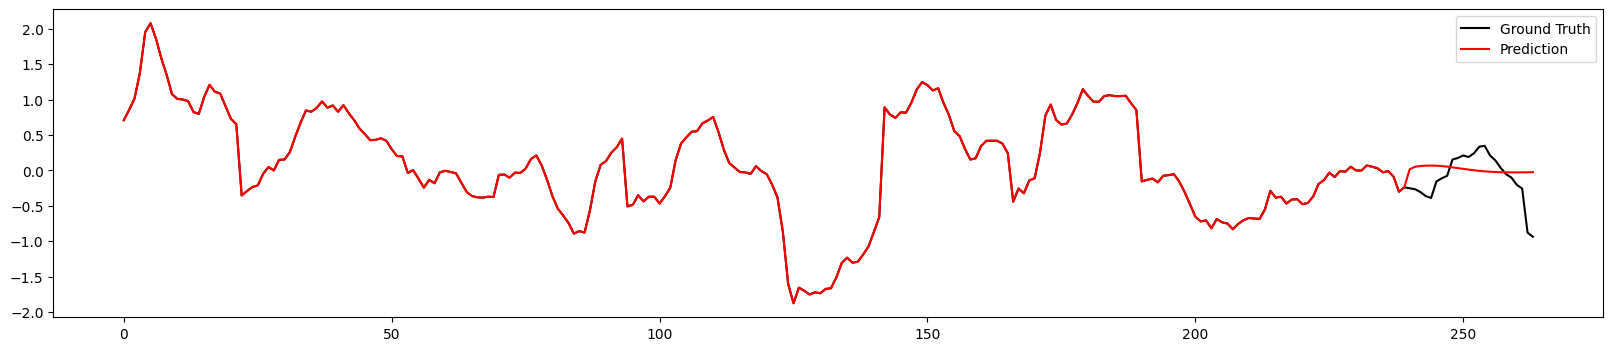

torch.Size([64, 24, 4])
DAYTON_MW


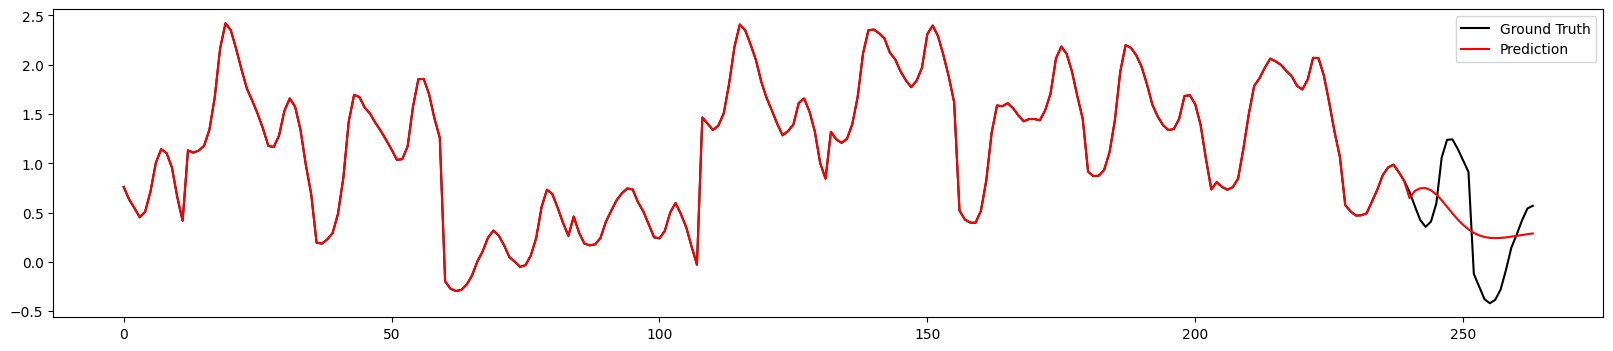

DAYTON_MW_Diff


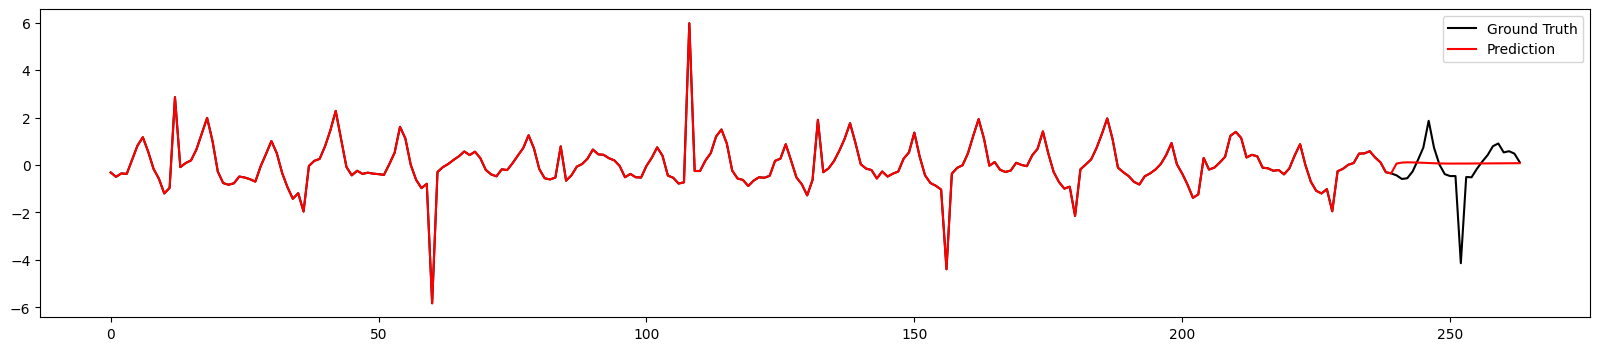

DAYTON_MW_DailyAvg


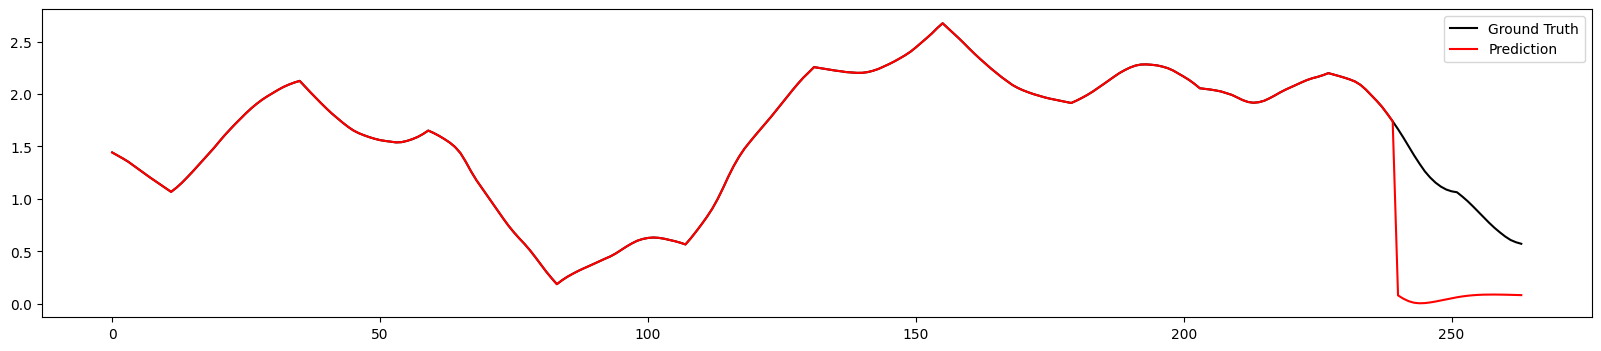

DAYTON_MW_DailyDiff


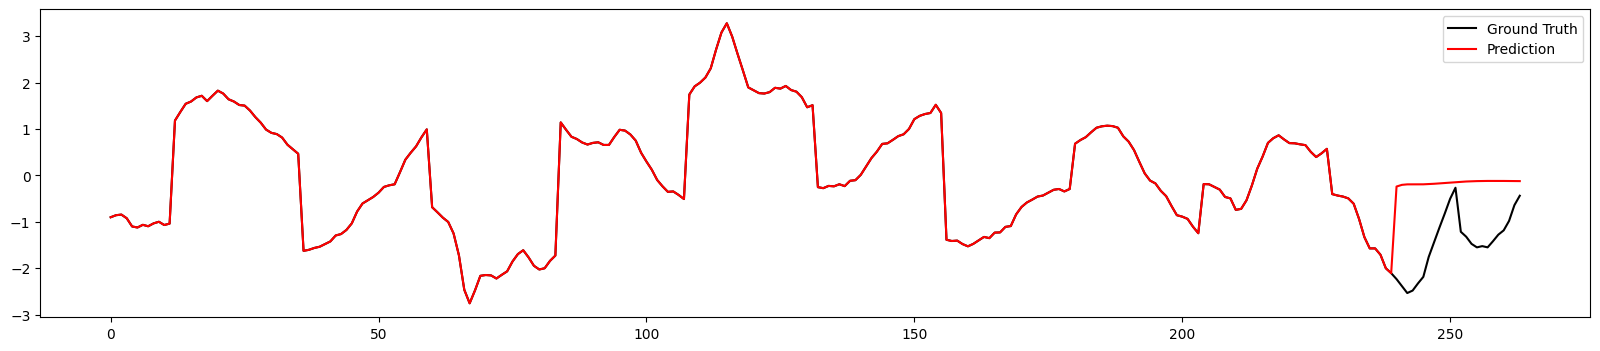

torch.Size([64, 24, 4])
DAYTON_MW


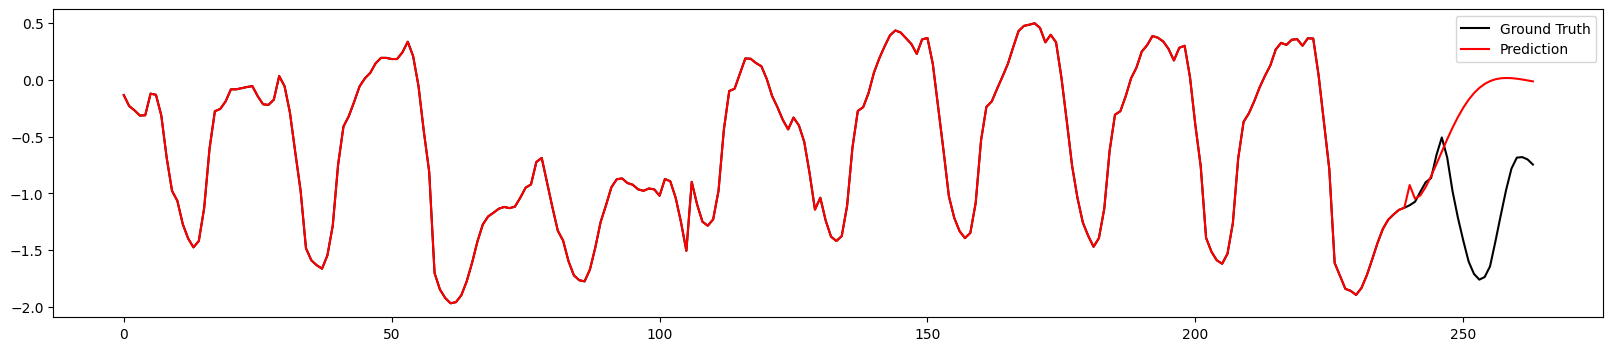

DAYTON_MW_Diff


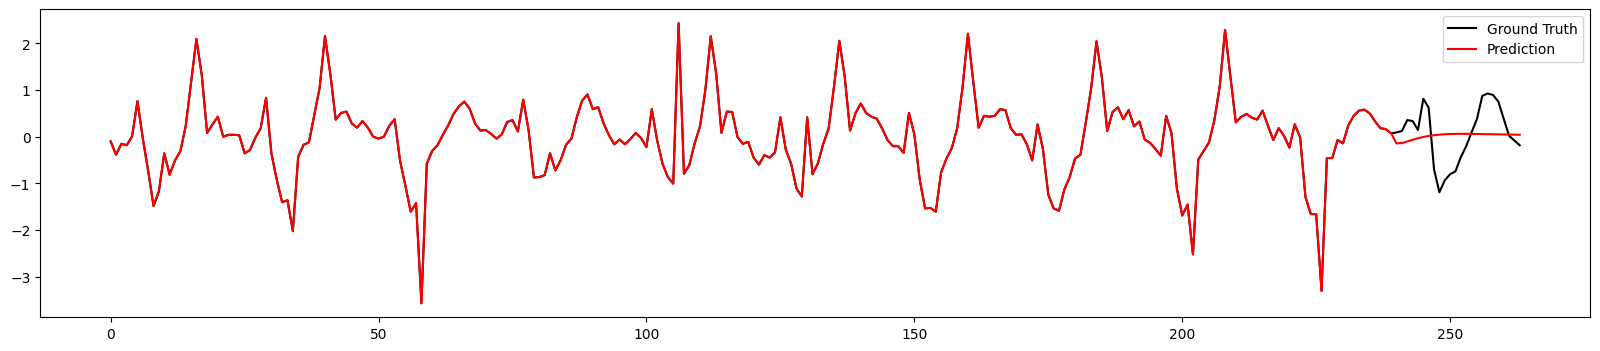

DAYTON_MW_DailyAvg


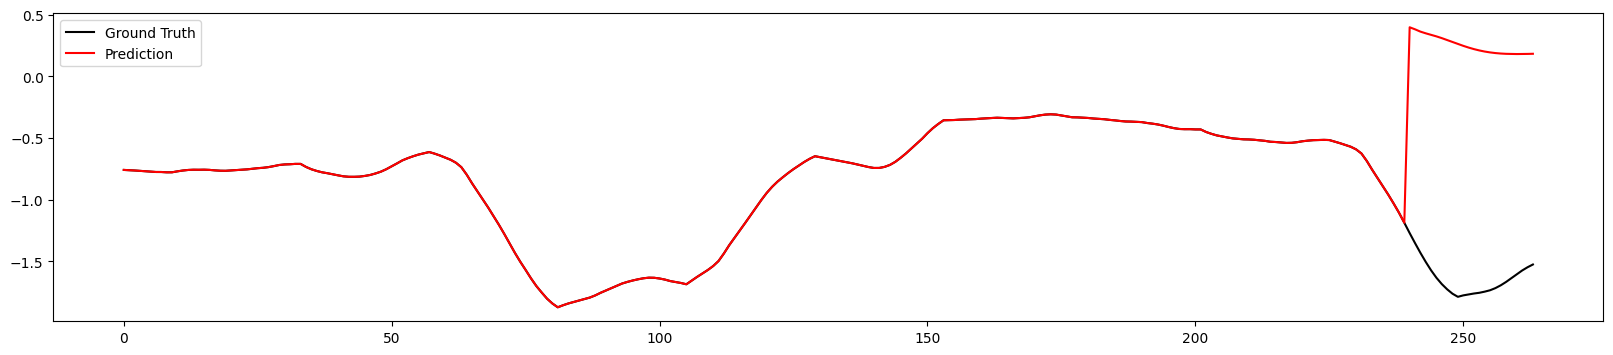

DAYTON_MW_DailyDiff


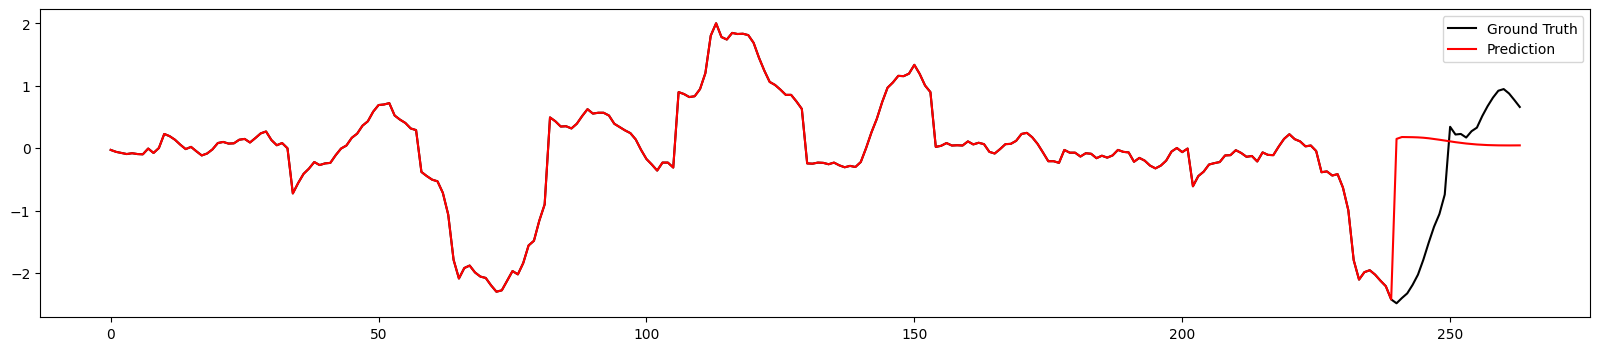

torch.Size([64, 24, 4])
DAYTON_MW


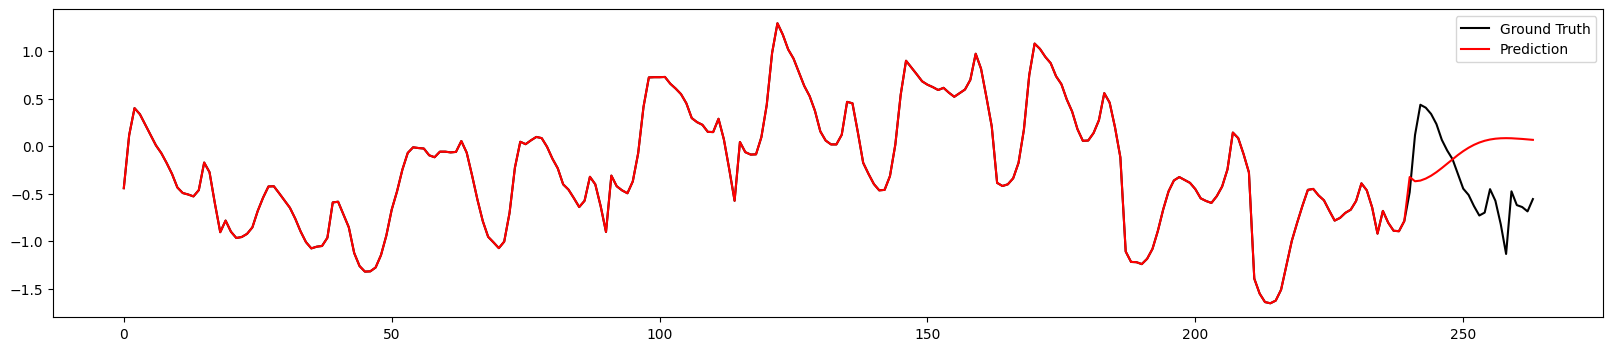

DAYTON_MW_Diff


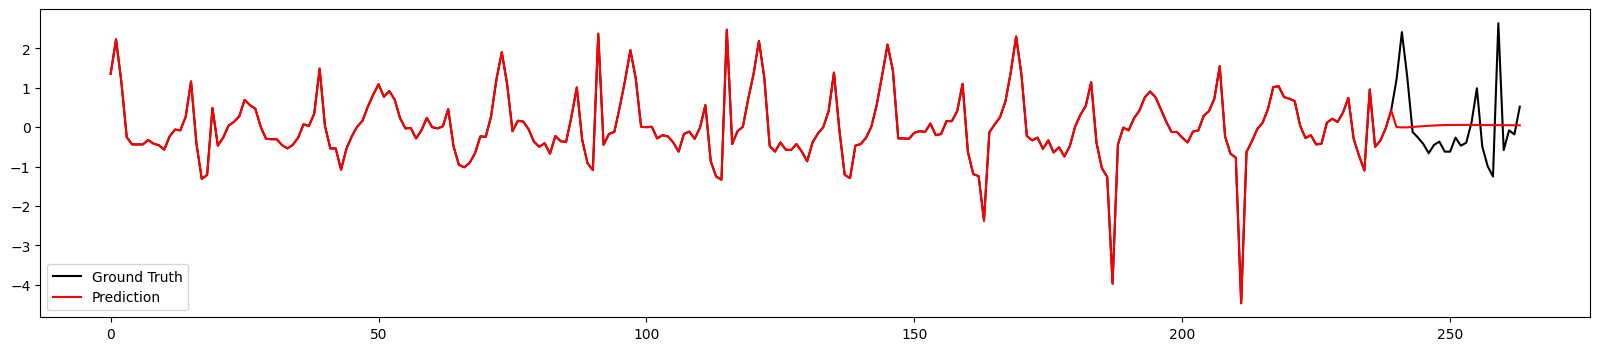

DAYTON_MW_DailyAvg


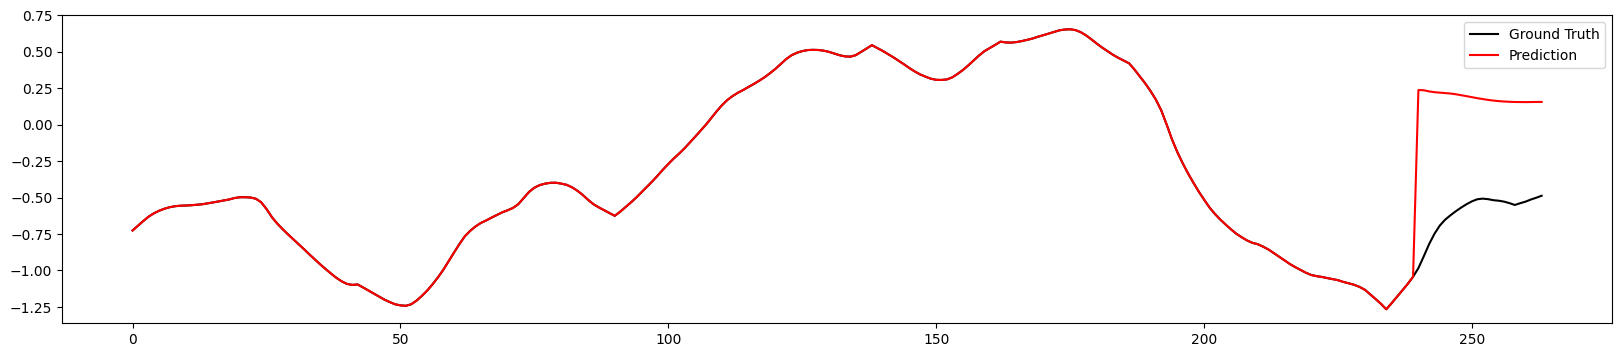

DAYTON_MW_DailyDiff


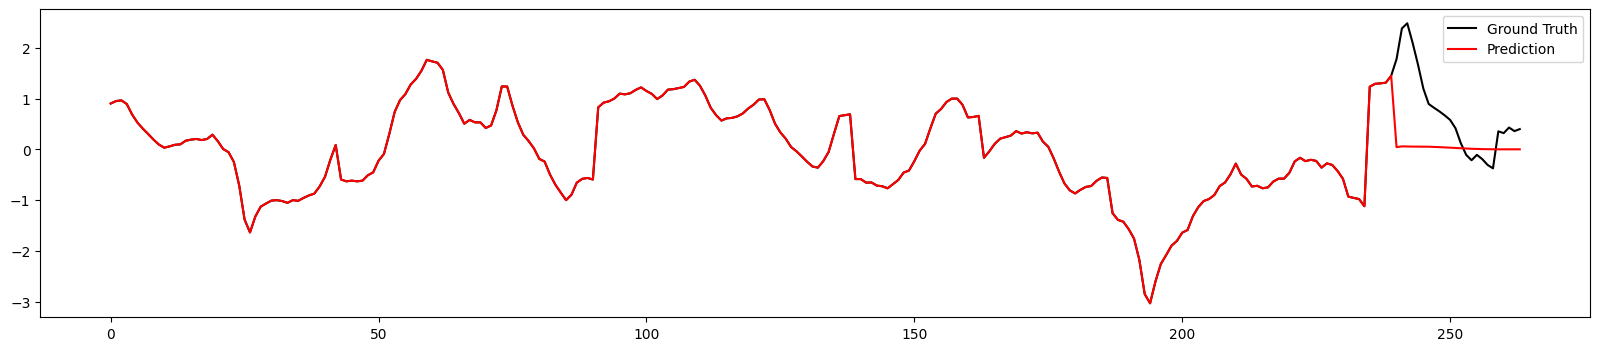

torch.Size([64, 24, 4])
DAYTON_MW


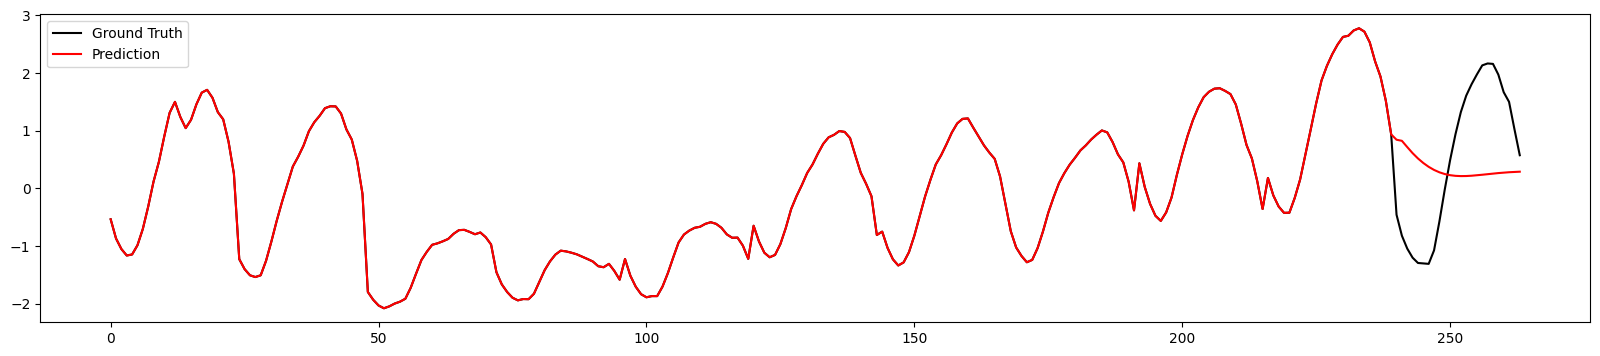

DAYTON_MW_Diff


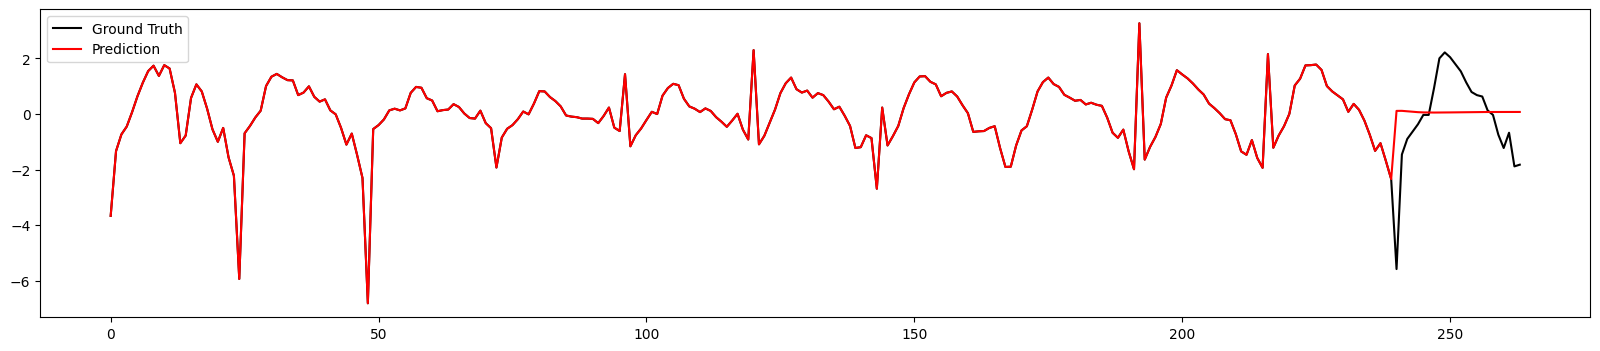

DAYTON_MW_DailyAvg


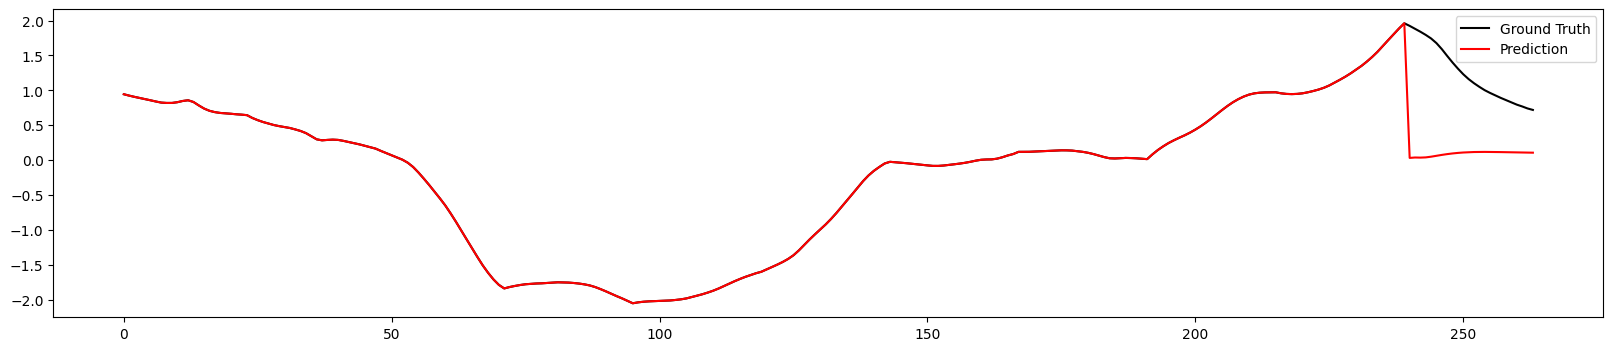

DAYTON_MW_DailyDiff


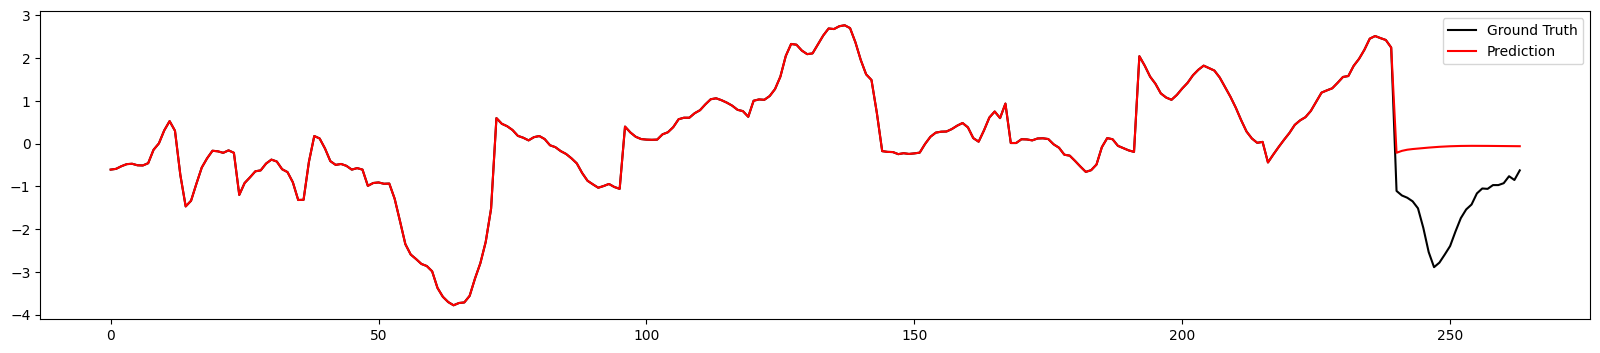

torch.Size([64, 24, 4])
DAYTON_MW


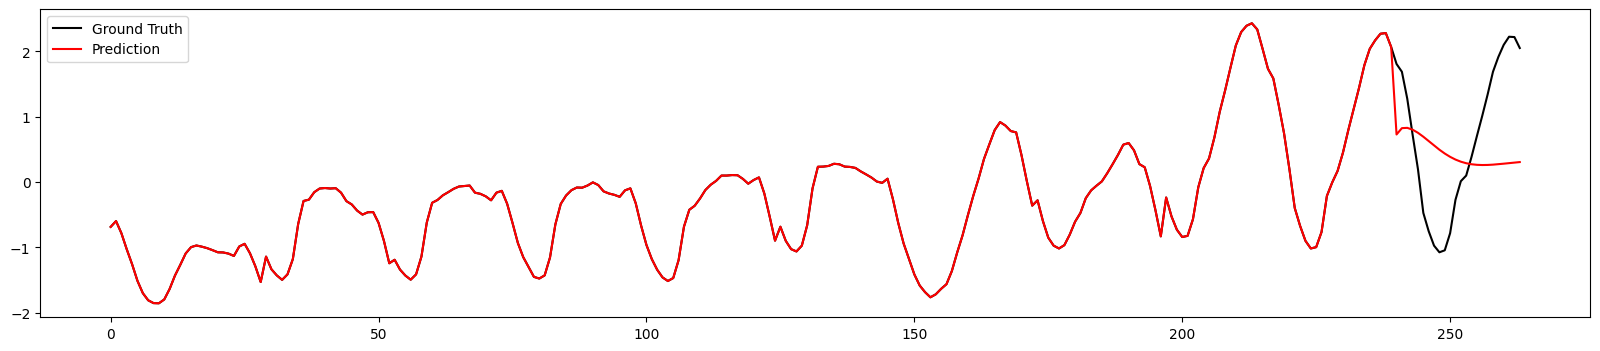

DAYTON_MW_Diff


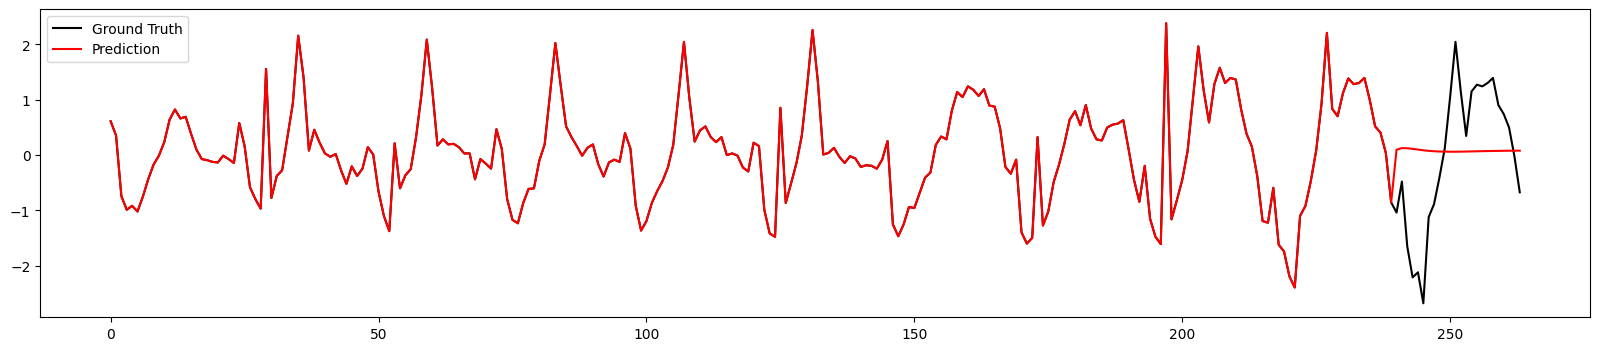

DAYTON_MW_DailyAvg


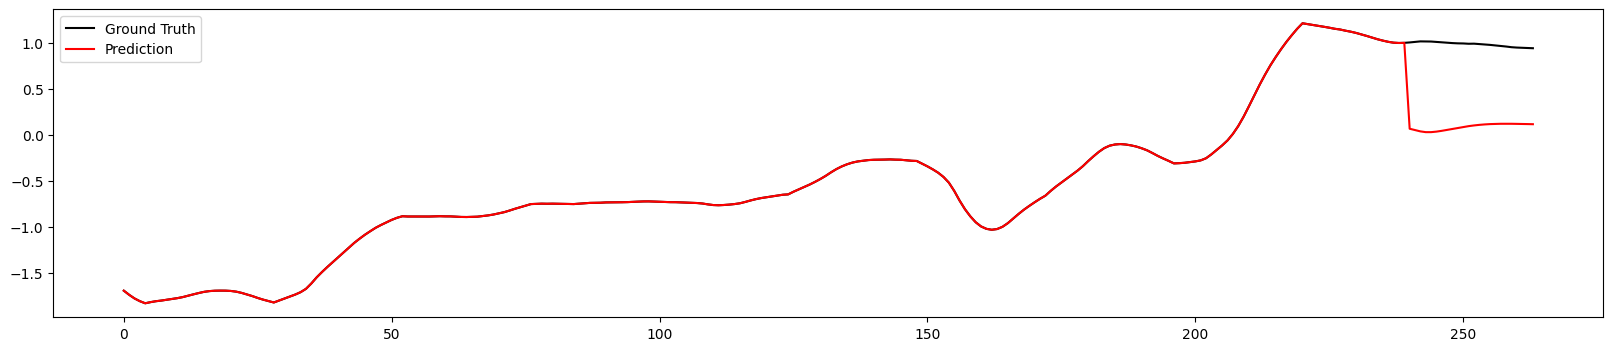

DAYTON_MW_DailyDiff


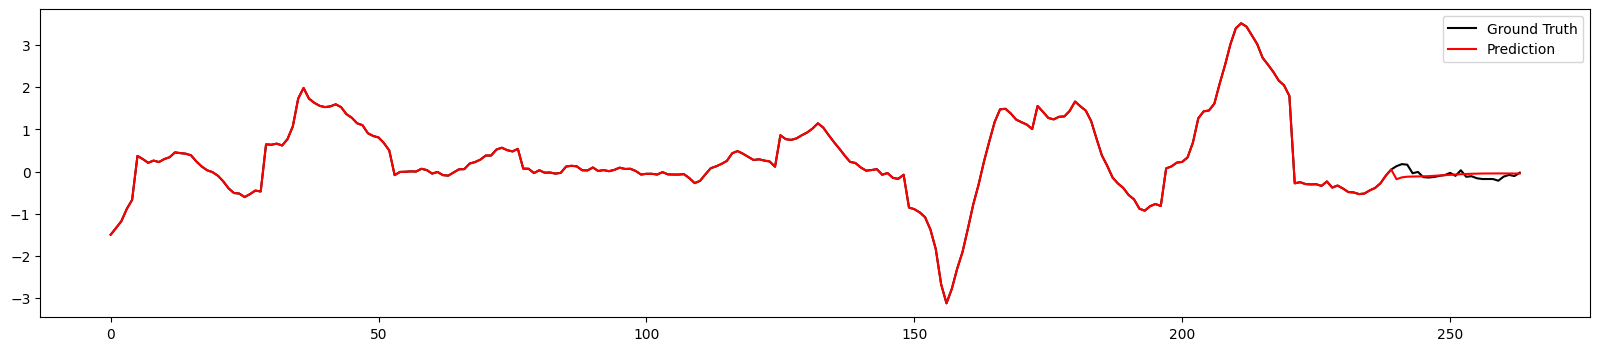

torch.Size([64, 24, 4])
DAYTON_MW


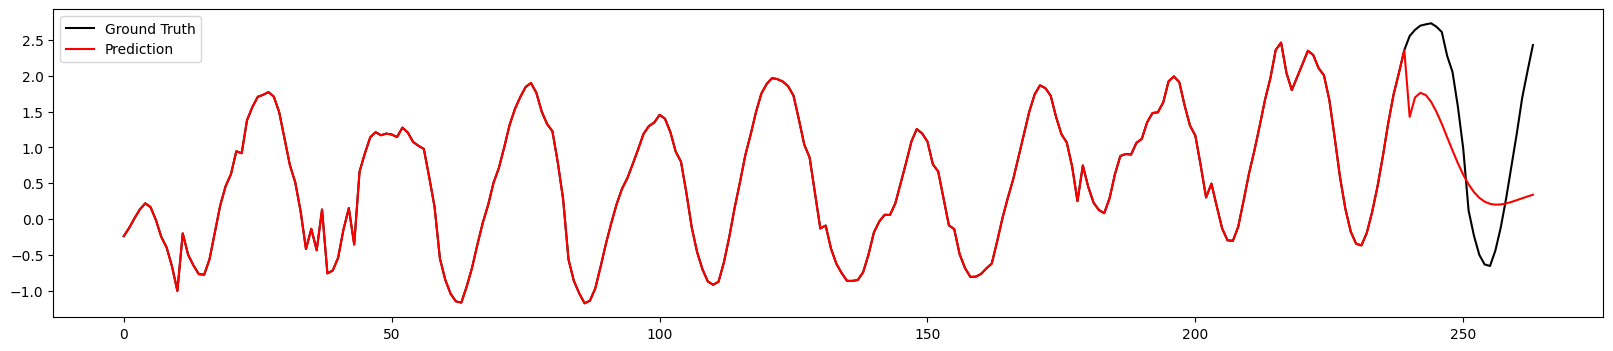

DAYTON_MW_Diff


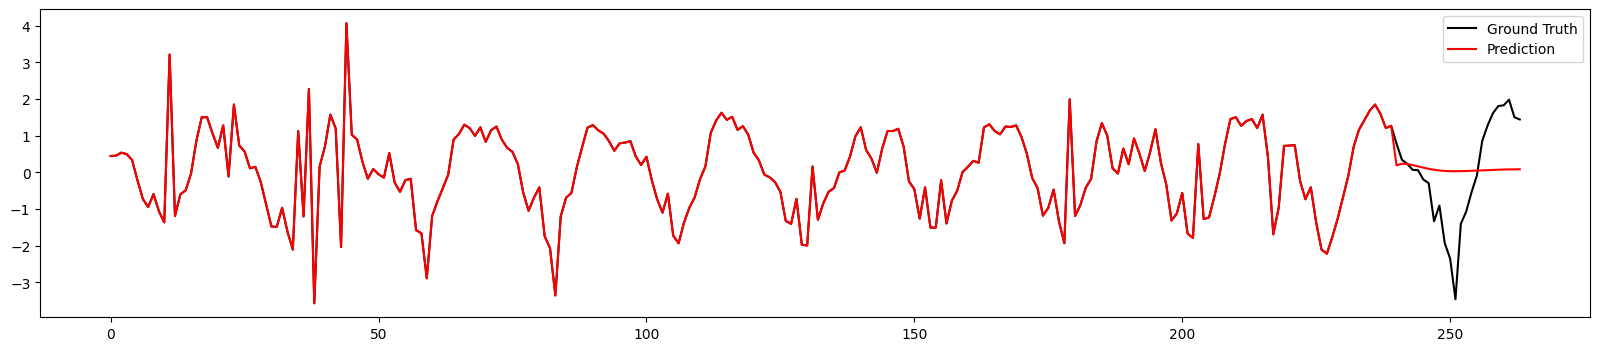

DAYTON_MW_DailyAvg


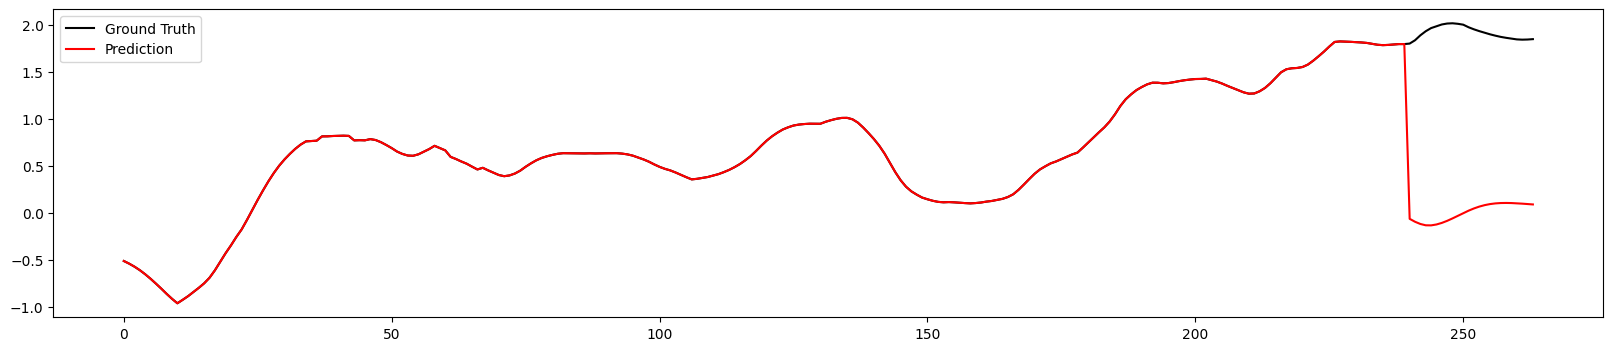

DAYTON_MW_DailyDiff


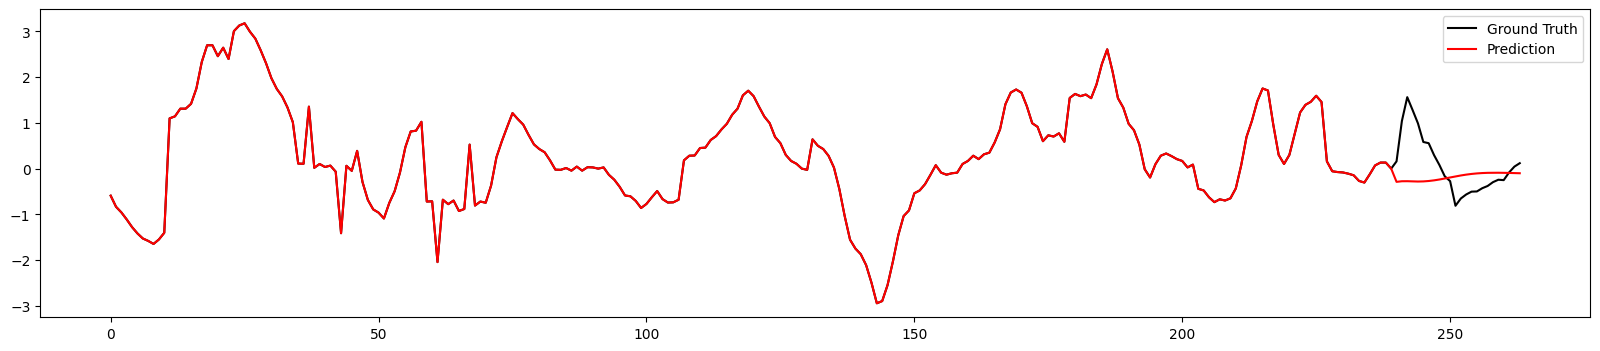

torch.Size([64, 24, 4])
DAYTON_MW


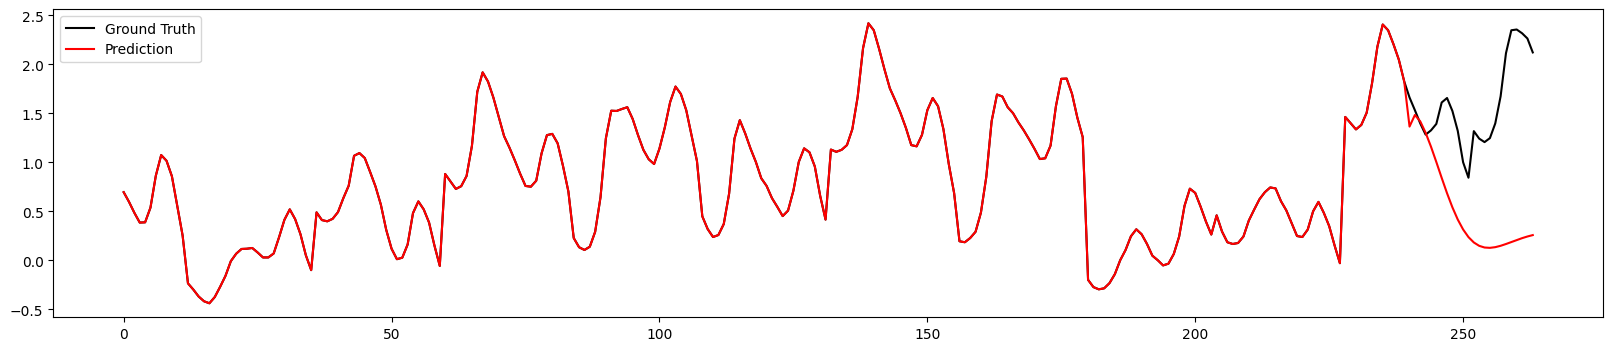

DAYTON_MW_Diff


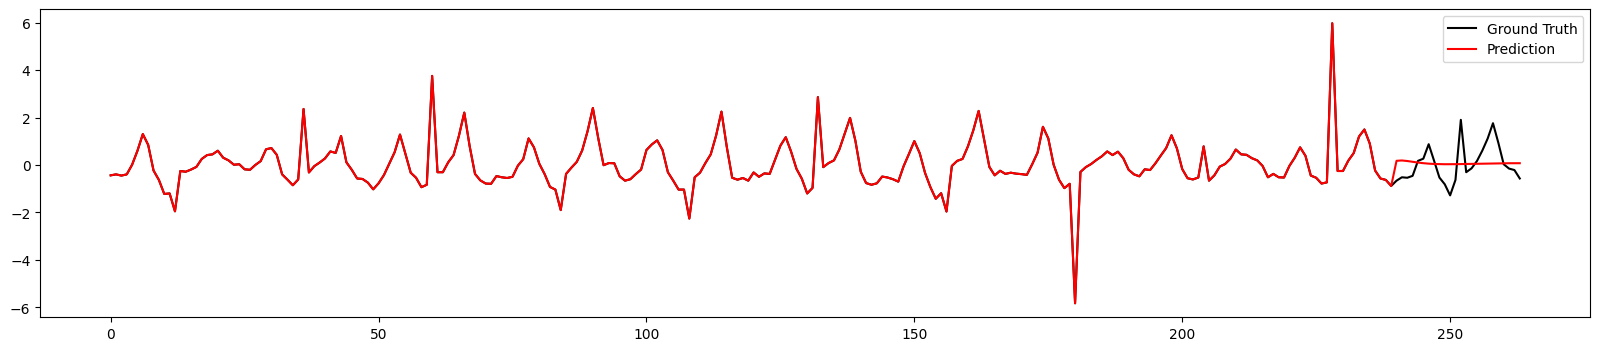

DAYTON_MW_DailyAvg


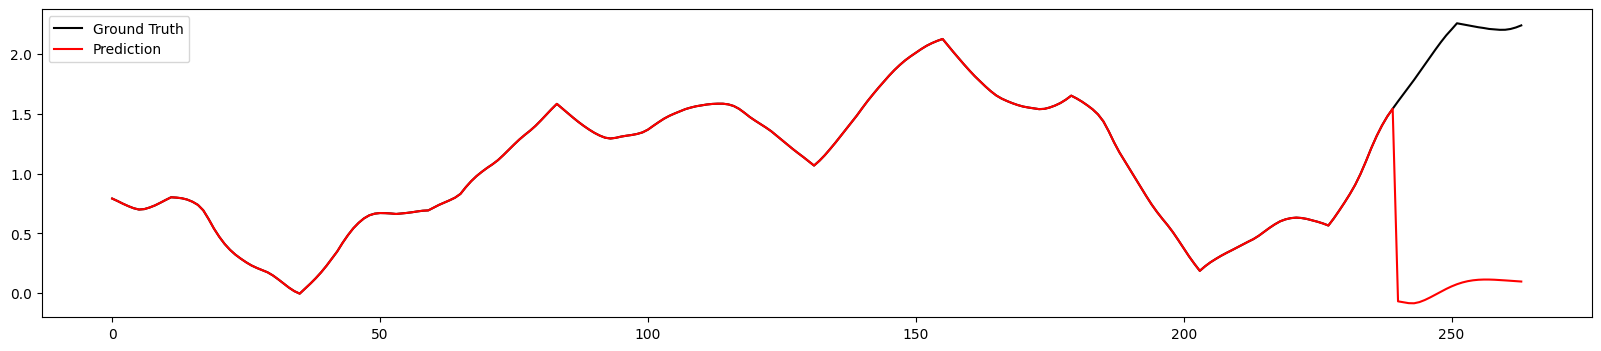

DAYTON_MW_DailyDiff


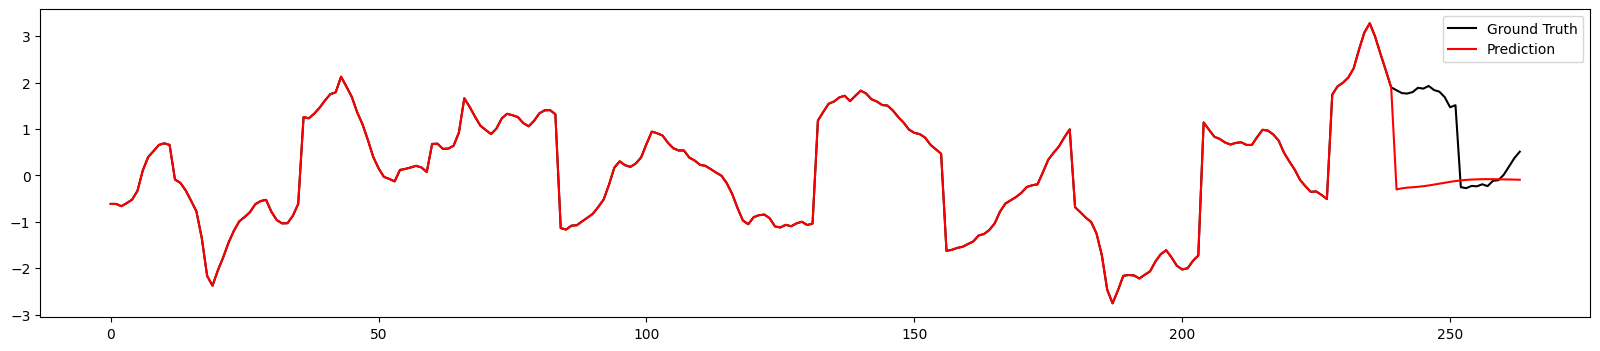

torch.Size([64, 24, 4])
DAYTON_MW


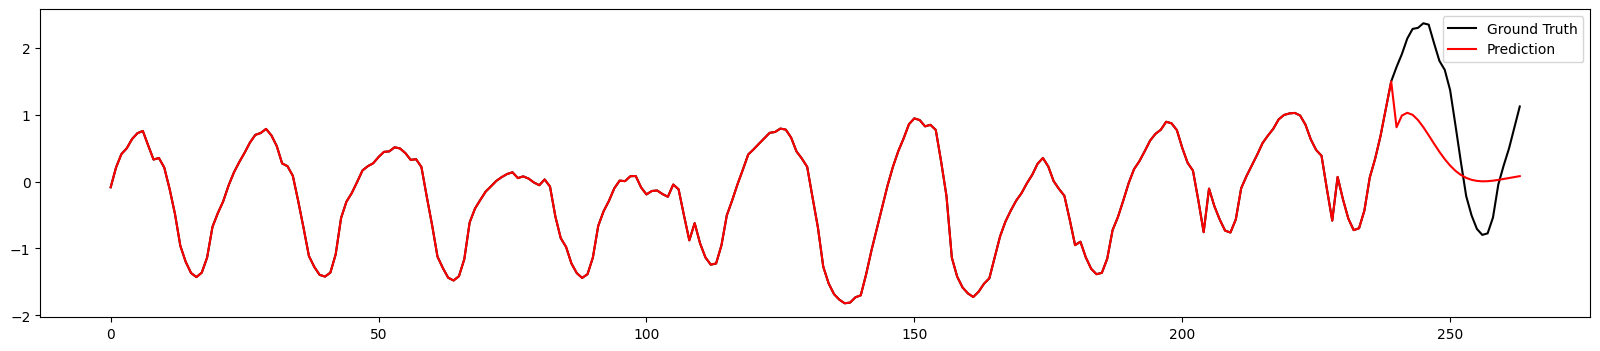

DAYTON_MW_Diff


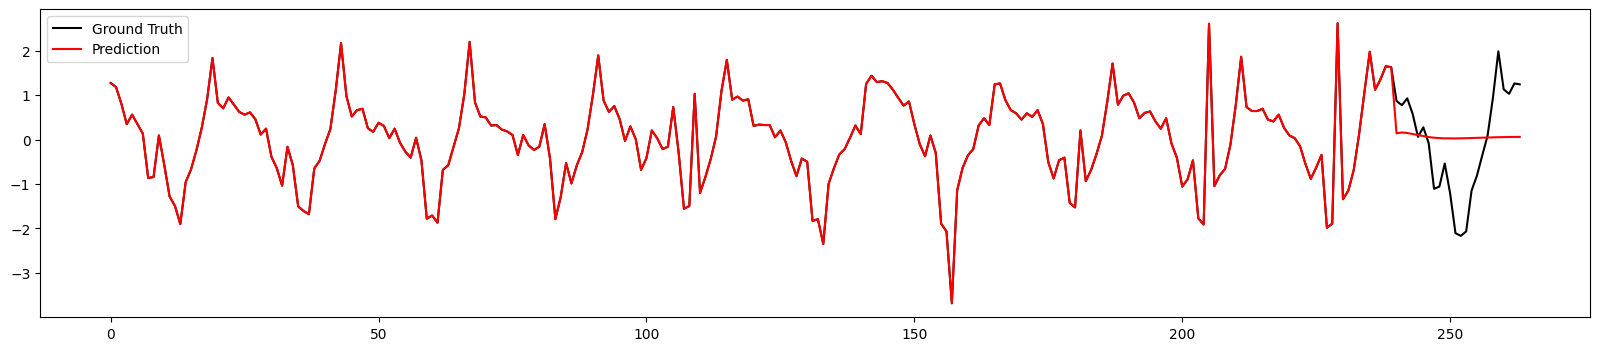

DAYTON_MW_DailyAvg


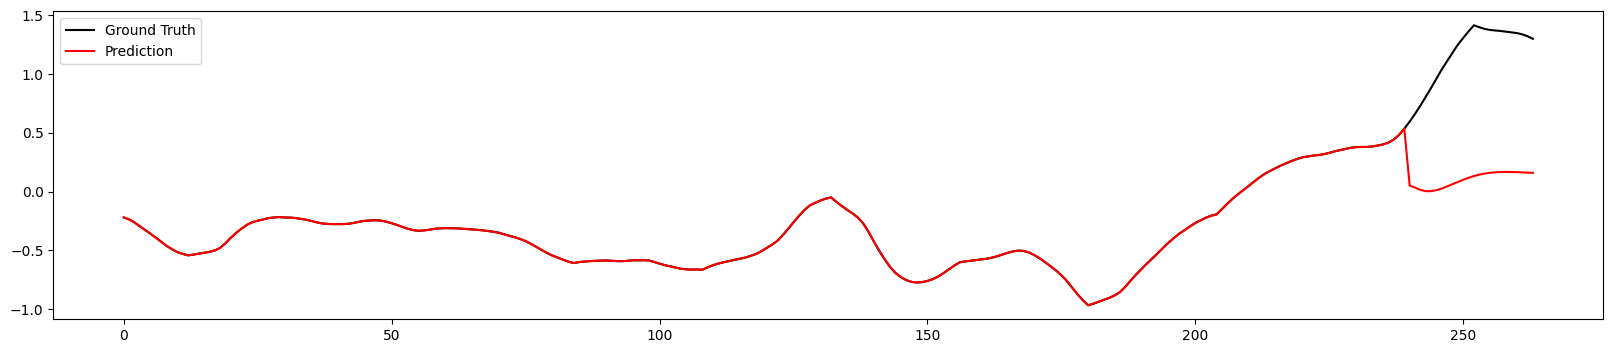

DAYTON_MW_DailyDiff


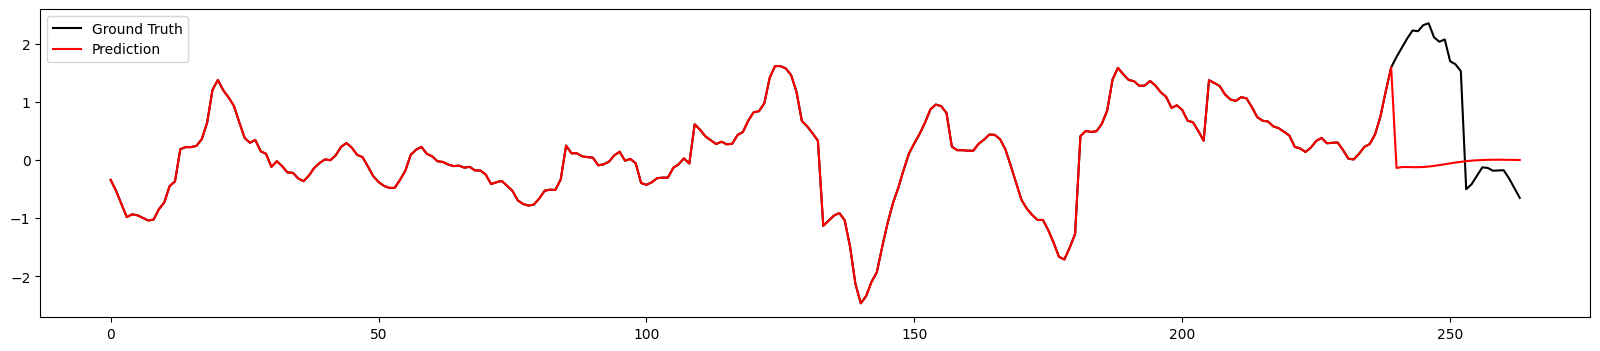

In [ ]:

for _ in range(10):
    model.eval()
    samples, targets = next(val_generator)
    output = make_predictions(model, samples, targets)
    print(output.shape)

    plot_predictions(samples, targets, output)